In [1]:

!pip install  transformers datasets
!pip install  captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 131.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you h

In [1]:
import os
os.makedirs("plots", exist_ok=True)


In [2]:
# 2) Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification




# 3) Load the test CSV and extract utterances
csv_path = "/content/train_sent_emo_cleaned_processed.csv"
df = pd.read_csv(csv_path)
# 4) Load EmoBERTa tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base", output_attentions=True) # Add output_attentions=True
model.eval()
model.to(torch.device("cpu"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [3]:
if "Utterance" in df.columns:
    text= df["Utterance"].iloc[6]
else:
    text = df.iloc[0, 0]

print(f"First utterance: {text}")


First utterance: I see.


In [4]:
# Cell 1: Load data, model, and run inference over the entire test set
# Assume column is named "utterance"; otherwise use first column
if "Utterance" in df.columns:
    utterances = df["Utterance"].tolist()
else:
    utterances = df.iloc[:, 0].tolist()

# 4) Load EmoBERTa tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
model.to(torch.device("cpu"))

# 5) Run inference on every utterance and store predicted indices
all_predictions = []
for text in utterances:
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    with torch.no_grad():
        logits = model(enc["input_ids"], attention_mask=enc["attention_mask"]).logits
        pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()
    all_predictions.append(pred_idx)

print(f"Ran inference on {len(utterances)} utterances.")

# 6) Print out the first utterance and its predicted index
first_text = utterances[0]
first_pred_idx = all_predictions[0]
print(f"First utterance: {first_text}")
print(f"Predicted label index: {first_pred_idx}")


Ran inference on 9988 utterances.
First utterance: also I was the point person on my company’s transition from the KL-5 to GR-6 system.
Predicted label index: 0


Final Layer Attention Visualization

First utterance: "That was a good one. For a second there, I was like, "whoa.""
Predicted emotion: joy  (index 1)

Top 5 tokens by final-layer [CLS]→token attention:
          who → 0.0891
            a → 0.0856
            . → 0.0826
           ." → 0.0750
           Ġ" → 0.0612


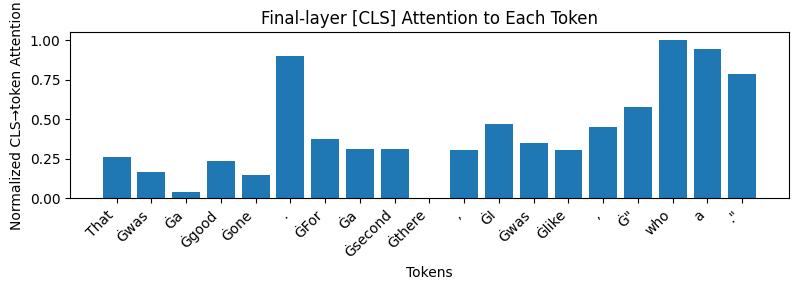

In [ ]:

# 3) Tokenize (pad/truncate to length 128)
encoding = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids = encoding["input_ids"]           # shape: (1, 128)
attention_mask = encoding["attention_mask"] # shape: (1, 128)

# 4) Forward pass → get logits & attentions
with torch.no_grad():
    outputs = model(
        input_ids,
        attention_mask=attention_mask,
        output_attentions=True,
    )
    logits = outputs.logits                    # shape: (1, num_labels)
    attentions = outputs.attentions            # tuple of length num_layers

# 5) Compute predicted emotion label
pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()
# id2label is a dict mapping index → emotion string
id2label = model.config.id2label
predicted_emotion = id2label[pred_idx]

print(f'First utterance: "{text}"')
print(f"Predicted emotion: {predicted_emotion}  (index {pred_idx})\n")

# 6) Extract “CLS → token” attention from the last layer
#    attentions[-1]: shape (1, num_heads, L, L); squeeze batch dim → (num_heads, L, L)
last_layer_attn = attentions[-1].squeeze(0)  # (num_heads, L, L)

# 7) For each head h, take the row i=0 (CLS position) → shape (num_heads, L)
cls_to_all = last_layer_attn[:, 0, :]         # (num_heads, L)
#  average over heads → (L,)
cls_importance = cls_to_all.mean(dim=0).cpu().numpy()

# 8) Map back to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())  # length L=128

# 9) Pair (token, score), filter out special tokens & [PAD]
pairs = [
    (tok, float(score))
    for tok, score in zip(tokens, cls_importance)
    if tok not in tokenizer.all_special_tokens and tok != "[PAD]"
]

# 10) Sort descending by attention score and print top 5
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
print("Top 5 tokens by final-layer [CLS]→token attention:")
for tok, score in pairs_sorted[:5]:
    print(f"   {tok:>10} → {score:.4f}")

# 11) (Optional) Bar chart of normalized scores over all tokens
words = [tok for tok, _ in pairs]
scores = np.array([s for _, s in pairs])
# Normalize to [0,1]:
norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

plt.figure(figsize=(max(8, len(words)*0.3), 3))
plt.bar(range(len(words)), norm)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.ylabel("Normalized CLS→token Attention")
plt.xlabel("Tokens")
plt.title("Final-layer [CLS] Attention to Each Token")
plt.tight_layout()
plt.savefig("plots/cell2_cls_attention.png", bbox_inches="tight")

plt.show()


Layer Integrated Gradients

In [ ]:
from captum.attr import LayerIntegratedGradients
from captum.attr import IntegratedGradients

Number of layers: 13, number of axes slots: 15


/tmp/ipython-input-249164845.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
/tmp/ipython-input-249164845.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
/tmp/ipython-input-249164845.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
/tmp/ipython-input-249164845.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_tokens, rotation=45, ha="right")
/tmp/ipython-input-249164845.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of tic

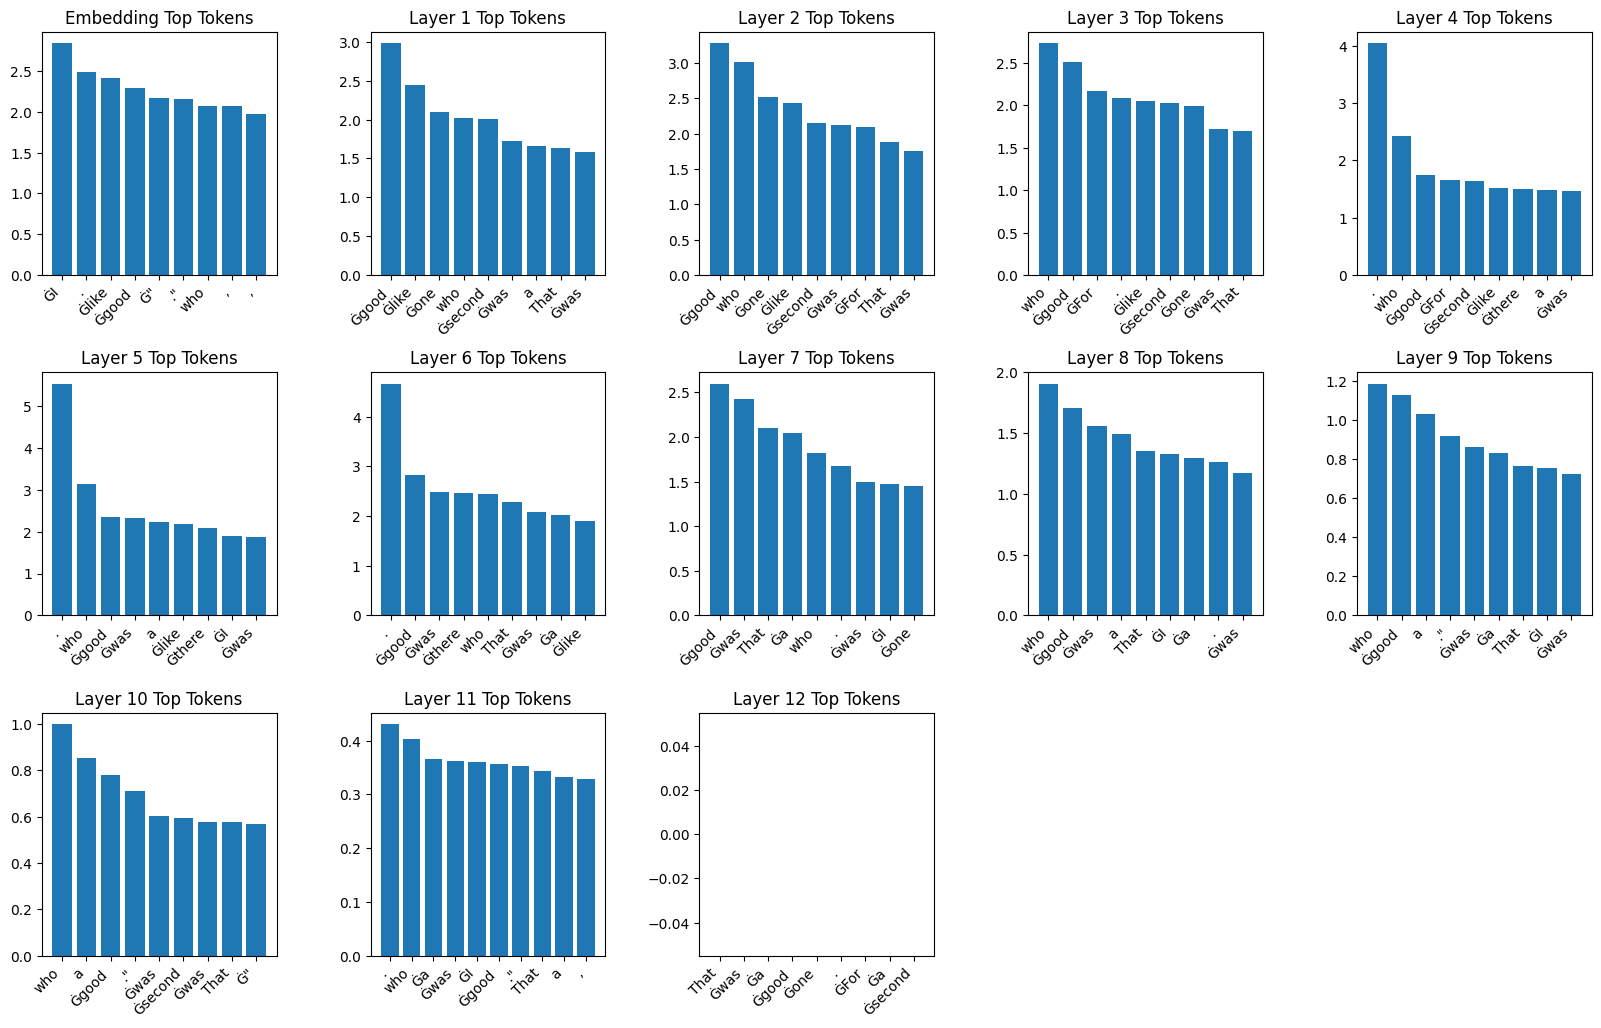

In [ ]:



# Βεβαιωνόμαστε ότι δουλεύουμε σε CPU
device = torch.device("cpu")
# Αποφεύγουμε να καλούμε model.to(device) με GPU
model.to(device)

# 2) Συνάρτηση forward_from_embs
def forward_from_embs(emb, attn_mask):
    out = model(inputs_embeds=emb, attention_mask=attn_mask).logits
    return out

# 3) Επιλογή ενός παραδείγματος κειμένου
enc = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids = enc["input_ids"].to(device)
attention_mask = enc["attention_mask"].to(device)

# 4) Υπολογισμός embeddings και baseline embeddings
embeds = model.roberta.embeddings(input_ids)
pad_id = tokenizer.pad_token_id
baseline_ids = torch.full_like(input_ids, pad_id)
baseline_embeds = model.roberta.embeddings(baseline_ids)

# 5) Προβλεπόμενη κλάση
with torch.no_grad():
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    pred_idx = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()

# 6) Δημιουργία λίστας στρωμάτων: πρώτα το embedding, μετά τα 12 encoder layers
layers = [model.roberta.embeddings] + [model.roberta.encoder.layer[i].output for i in range(len(model.roberta.encoder.layer))]
num_layers = len(layers)  # 13 επίπεδα συνολικά

token_ids = input_ids.squeeze(0).cpu().tolist()
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# 7) Δημιουργία υποπλοκών: 3x5 = 15 θέσεις (θα μείνουν κενές 2)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()

print(f"Number of layers: {num_layers}, number of axes slots: {len(axes)}")

for idx, target_layer in enumerate(layers):
    # Όρισμα LayerIG για κάθε layer
    lig = LayerIntegratedGradients(lambda emb, mask: forward_from_embs(emb, mask)[:, pred_idx], target_layer)

    # Υπολογισμός attribution
    attributions = lig.attribute(
    inputs=embeds,
    baselines=baseline_embeds,
    additional_forward_args=(attention_mask,),
    n_steps=50
    )


    # Απόδοση σε επίπεδο token
    attributions = attributions.squeeze(0)  # [seq_len, hidden_dim]
    token_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [seq_len]

    # Φιλτράρισμα ειδικών tokens
    plot_tokens = []
    plot_scores = []
    for tok, score in zip(tokens, token_attr):
        if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
            continue
        plot_tokens.append(tok)
        plot_scores.append(score)

    # Top 10 tokens
    top_pairs = sorted(zip(plot_tokens, plot_scores), key=lambda x: x[1], reverse=True)[:10]
    if top_pairs:
        top_tokens, top_scores = zip(*top_pairs)
    else:
        top_tokens, top_scores = [], []

    # Σχεδίαση bar plot
    if idx >= len(axes):  # αν τυχόν έχουμε περισσότερα layers από subplots
        break
    ax = axes[idx]
    ax.bar(top_tokens, top_scores)
    layer_name = "Embedding" if idx == 0 else f"Layer {idx}"
    ax.set_title(f"{layer_name} Top Tokens")
    ax.set_xticklabels(top_tokens, rotation=45, ha="right")

# Αφαίρεση τυχόν κενών υποπλοκών
for j in range(num_layers, len(axes)):
    fig.delaxes(axes[j])

# Αυξημένες αποστάσεις μεταξύ υποπλοκών
plt.subplots_adjust(hspace=0.4, wspace=0.4)
# 6) Αποθήκευση όλου του figure σε αρχείο
fig.savefig("plots/all_layers_top_tokens.png", dpi=200, bbox_inches="tight")

# 7) Εμφάνιση στην οθόνη
plt.show()

Predicted emotion: joy  (index 1)

Convergence delta: 1.374795

Raw BPE tokens (repr):
 00 │ '<s>'         → attribution -0.0097
 01 │ 'That'        → attribution 0.0077
 02 │ 'Ġwas'        → attribution 0.3193
 03 │ 'Ġa'          → attribution 0.1014
 04 │ 'Ġgood'       → attribution 1.1901
 05 │ 'Ġone'        → attribution 0.6228
 06 │ '.'           → attribution 0.2518
 07 │ 'ĠFor'        → attribution -0.3193
 08 │ 'Ġa'          → attribution -0.1268
 09 │ 'Ġsecond'     → attribution -0.1623
 10 │ 'Ġthere'      → attribution -0.0680
 11 │ ','           → attribution -0.1998
 12 │ 'ĠI'          → attribution 0.0718
 13 │ 'Ġwas'        → attribution 0.0587
 14 │ 'Ġlike'       → attribution 0.6297
 15 │ ','           → attribution 0.1939
 16 │ 'Ġ"'          → attribution -0.1575
 17 │ 'who'         → attribution 0.2755
 18 │ 'a'           → attribution -0.2689
 19 │ '."'          → attribution 0.7037
 20 │ '</s>'        → attribution 0.7017
 21 │ '<pad>'       → attribution 0.0000
 22

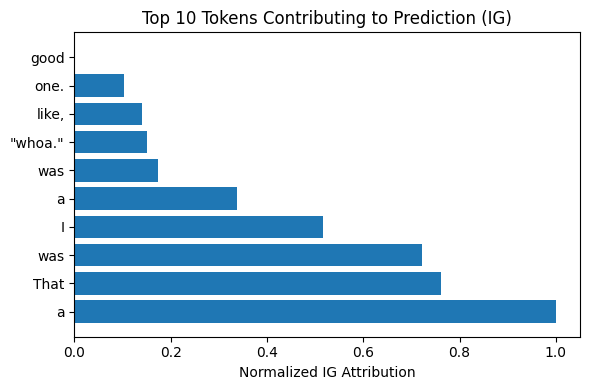

In [ ]:

# 4) Tokenize with max_length=64 to reduce memory usage
encoding = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=64
)
input_ids = encoding["input_ids"].to(device)           # shape: (1, 64)
attention_mask = encoding["attention_mask"].to(device) # shape: (1, 64)

# 5) Run a forward pass to get the model’s predicted class index
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits               # (1, num_labels)
    probs = torch.softmax(logits, dim=-1)
    pred_idx = torch.argmax(probs, dim=-1).item()

id2label = model.config.id2label
predicted_emotion = id2label[pred_idx]
print(f"Predicted emotion: {predicted_emotion}  (index {pred_idx})\n")

# 6) Define a forward function for LayerIntegratedGradients
#    It should accept exactly (input_ids, attention_mask) and return the scalar logit for pred_idx
def forward_func(input_ids_, attention_mask_):
    """
    input_ids_:      (1, seq_len)
    attention_mask_: (1, seq_len)
    Returns:         (1,) tensor = logit for the predicted class (pred_idx)
    """
    out = model(input_ids_, attention_mask=attention_mask_)
    return out.logits[:, pred_idx]  # shape: (1,)

# 7) Build a baseline of all [MASK] tokens (instead of [PAD]) to reduce function-word bias
mask_id = tokenizer.mask_token_id
baseline_ids = torch.full_like(input_ids, mask_id).to(device)

# 8) Instantiate LayerIntegratedGradients with respect to the embedding layer
lig = LayerIntegratedGradients(
    forward_func,
    model.roberta.embeddings.word_embeddings
)

# 9) Compute attributions
#    - inputs = actual input_ids
#    - baselines = baseline_ids (all [MASK] tokens)
#    - additional_forward_args = (attention_mask,)
#    - return_convergence_delta = True
#    - n_steps = 50 for smoother approximation
attributions, delta = lig.attribute(
    inputs=input_ids,
    baselines=baseline_ids,
    additional_forward_args=(attention_mask,),
    return_convergence_delta=True,
    n_steps=10####### more steps more stabillity
)
# attributions: shape (1, seq_len, hidden_dim)
# delta: single tensor (convergence measure)

# 10) Sum attributions across the hidden‐dimension → one scalar per token
#     → shape (seq_len,)
token_attributions = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()

print(f"Convergence delta: {delta.item():.6f}\n")

# 11) Convert input IDs back to BPE tokens (length = 64)
raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().tolist())

# 12) Print out each raw token with repr(...) so we can see its exact Unicode form
print("Raw BPE tokens (repr):")
for i, tok in enumerate(raw_tokens):
    print(f" {i:02d} │ {repr(tok):<12}  → attribution {token_attributions[i]:.4f}")
print()

# 13) Pair (token, attribution_score) but filter out any special tokens & [PAD]
pairs = []
for tok, score in zip(raw_tokens, token_attributions):
    # `tokenizer.all_special_tokens` contains "<s>", "</s>", "<pad>", "<mask>", "<unk>", etc.
    if tok not in tokenizer.all_special_tokens and tok != tokenizer.pad_token:
        pairs.append((tok, float(score)))

# 14) Merge BPE subwords into full words, summing their scores
def merge_bpe_subwords(token_score_pairs):
    """
    Merges RoBERTa byte‐BPE tokens into complete words.
    Rule: If a token starts with the single character "Ġ" (U+0120),
    that indicates the start of a new word (strip off "Ġ" to begin).
    Otherwise, it is a continuation of the previous word.
    """
    merged = []
    current_word = ""
    current_score = 0.0

    for tok, sc in token_score_pairs:
        if tok.startswith("Ġ"):
            # Commit the previous word if it exists
            if current_word:
                merged.append((current_word, current_score))
            # Start a brand‐new word: strip off the leading U+0120 "Ġ"
            current_word = tok.replace("Ġ", "", 1)
            current_score = sc
        else:
            # Continuation subword: append literally, accumulate score
            current_word += tok
            current_score += sc

    # Append the last word
    if current_word:
        merged.append((current_word, current_score))
    return merged

merged = merge_bpe_subwords(pairs)

# 15) Sort merged words by attribution descending and print the top 10
merged_sorted = sorted(merged, key=lambda x: x[1], reverse=True)

print("Top 10 words by Integrated Gradients attribution (after merging):")
for word, score in merged_sorted[:10]:
    print(f"   {word:>12} → {score:.4f}")

# 16) (Optional) Plot a horizontal bar chart of those top 10 (normalized to [0,1])
topk = merged_sorted[:10]
words = [w for w, _ in topk]
scores_topk = np.array([s for _, s in topk])
# Normalize so the largest maps to 1.0
norm_scores = (scores_topk - scores_topk.min()) / (scores_topk.max() - scores_topk.min() + 1e-10)

plt.figure(figsize=(6, 4))
plt.barh(range(len(words))[::-1], norm_scores[::-1], align="center")
plt.yticks(range(len(words)), words[::-1])
plt.xlabel("Normalized IG Attribution")
plt.title("Top 10 Tokens Contributing to Prediction (IG)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install captum

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients


texts = df["Utterance"].tolist()

# 3) Ορίζουμε (ξανά) ακριβώς τη συνάρτηση με το σωστό όνομα:
def explain_predicted_with_embs(text, tokenizer, model, device, max_length=128, n_steps=20):
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)         # LongTensor [1, max_length]
    attention_mask = enc["attention_mask"].to(device)

    # (β) Προβλεπόμενη κλάση
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits  # [1, num_labels]
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    # (γ) Πραγματικά embeddings για το input
    embeds = model.roberta.embeddings(input_ids)     # [1, max_length, hidden_dim]

    # (δ) Baseline: όλοι PAD tokens
    pad_id = tokenizer.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_id)       # [1, max_length]
    baseline_embeds = model.roberta.embeddings(baseline_ids)  # [1, max_length, hidden_dim]

    # (ε) Forward που δέχεται απευθείας embeddings + attention_mask → logit[pred_idx]
    def forward_from_embs(emb, attn_mask):
        out = model(
            inputs_embeds=emb,
            attention_mask=attn_mask
        ).logits               # [1, num_labels]
        return out[:, pred_idx]  # [1] (logit μόνο για την pred_idx κλάση)

    # (στ) Integrated Gradients
    ig = IntegratedGradients(forward_from_embs)
    attributions, delta = ig.attribute(
        inputs=embeds,
        baselines=baseline_embeds,
        additional_forward_args=(attention_mask,),
        return_convergence_delta=True,
        n_steps=n_steps
    )

    # (ζ) Μετατροπή από [1, max_length, hidden_dim] → [max_length]
    attributions = attributions.squeeze(0)                       # [max_length, hidden_dim]
    token_level_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [max_length]

    # (η) Ανακτούμε tokens για να τα ταιριάξουμε με τα scores
    token_ids = input_ids.squeeze(0).cpu().tolist()  # length = max_length
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return tokens, token_level_attr


# 4) Τώρα τρέχουμε τον βρόχο πάνω σε όλα τα κείμενα χρησιμοποιώντας
#    ακριβώς το explain_predicted_with_embs
rows = []
emotions = df["Emotion"].tolist()
for text, emotion in zip(texts, emotions):
    tokens, attr_vals = explain_predicted_with_embs(text, tokenizer, model, device)
    for tok, val in zip(tokens, attr_vals):
        # Φιλτράρουμε ειδικά tokens
        if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
            continue
        rows.append({
            "token": tok,
            "attribution": val,
            "emotion": emotion
        })

df_all = pd.DataFrame(rows)
print(df_all.shape)   # π.χ. (αρκετές χιλιάδες, 3)
print(df_all.head(10))

# Παράδειγμα: Θέλουμε το emotion "joy"
target_emotion = "joy"

# Φιλτράρουμε μόνο τις σειρές του df_all με emotion == "joy"
df_joy = df_all[df_all["emotion"] == target_emotion]

# Ομαδοποιούμε κατά token και υπολογίζουμε τη μέση τιμή attribution
df_summary_joy = (
    df_joy
    .groupby("token")["attribution"]
    .mean()
    .reset_index(name="mean_attribution")
)

# Ταξινομούμε σε φθίνουσα σειρά και κρατάμε τα top 10
df_top_joy = df_summary_joy.sort_values(by="mean_attribution", ascending=False).head(10)
print(df_top_joy)


In [ ]:

# 3) Attribution function that uses embeddings directly
def explain_predicted_with_embs(text, tokenizer, model, device, max_length=128, n_steps=20):
    # (a) Tokenize to get input_ids and attention_mask
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)         # LongTensor [1, max_length]
    attention_mask = enc["attention_mask"].to(device)

    # (b) Run one forward pass to get predicted class index
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits  # [1, num_labels]
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    # (c) Compute the actual embedding of this input (FloatTensor)
    #     If EmoBERTa is RoBERTa-based, its embeddings live under model.roberta.embeddings
    embeds = model.roberta.embeddings(input_ids)     # FloatTensor [1, max_length, hidden_dim]

    # (d) Build a “baseline” of all-[PAD] IDs, then get its embeddings
    pad_id = tokenizer.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_id)  # LongTensor [1, max_length]
    baseline_embeds = model.roberta.embeddings(baseline_ids)  # FloatTensor [1, max_length, hidden_dim]

    # (e) Define a forward function that takes embeddings + attention_mask → logit for pred_idx
    def forward_from_embs(emb, attn_mask):
        # emb: FloatTensor [1, max_length, hidden_dim]
        # attn_mask: LongTensor [1, max_length]
        out = model(
            inputs_embeds=emb,       # directly pass embedding vectors
            attention_mask=attn_mask
        ).logits                  # [1, num_labels]
        return out[:, pred_idx]   # [1], the logit for class=pred_idx

    # (f) Run IntegratedGradients over embeddings
    ig = IntegratedGradients(forward_from_embs)
    attributions, delta = ig.attribute(
        inputs=embeds,                     # FloatTensor baseline → real embedding
        baselines=baseline_embeds,         # FloatTensor [PAD]-only embedding
        additional_forward_args=(attention_mask,),
        return_convergence_delta=True,
        n_steps=n_steps                     # e.g. 20 or 50 steps of interpolation
    )

    # (g) Convert attributions from shape [1, max_length, hidden_dim] → [max_length]
    #     by summing across the embedding‐dimension
    #     (you could also take L2 norm or any other reduction, but sum is common)
    attributions = attributions.squeeze(0)                   # [max_length, hidden_dim]
    token_level_attr = attributions.abs().sum(dim=-1).cpu().tolist()  # [max_length] floats

    # (h) Recover token strings to align with those scores
    token_ids = input_ids.squeeze(0).cpu().tolist()        # length=max_length
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return tokens, token_level_attr

# 4) Example: run this on the first utterance and build a DataFrame of (token, attribution):
tokens0, attrs0 = explain_predicted_with_embs(text, tokenizer, model, device)

# Build a DataFrame for demonstration (filter out special tokens)
rows = []
for tok, val in zip(tokens0, attrs0):
    if tok in {tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token}:
        continue
    rows.append({"token": tok, "attribution": val})

import pandas as pd
df_tok0 = pd.DataFrame(rows)
print("First utterance token attributions:\n")
print(df_tok0)


LIME

In [ ]:
# 0) If you haven’t installed LIME already, run this once:
!pip install lime

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer


In [ ]:
# ============================
# 1) Configuration Parameters
# ============================
N_EXAMPLES      = 200     # Number of utterances to explain
NUM_FEATURES    = 6       # Number of top tokens LIME returns per class per utterance
NUM_SAMPLES     = 300     # Number of perturbed samples LIME uses (tradeoff speed vs. stability)
TOP_K           = 10      # Number of top tokens to display per class in final plots
MAX_SEQ_LENGTH  = 128     # Max token length for tokenizer

# Ensure device is defined (CPU or GPU)
device = torch.device("cpu")


print(f"Example utterance:\n{text}\n")
id2label    = model.config.id2label
class_names = [id2label[i] for i in range(len(id2label))]
num_classes = len(class_names)

# ============================
# 4) Define predict_proba for LIME
# ============================
def predict_proba(texts: list[str]) -> np.ndarray:
    """
    Given a list of raw utterance strings, return an (n_samples, n_labels) array of softmax probabilities.
    """
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQ_LENGTH
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask=enc["attention_mask"]).logits # Fixed attention_mask key
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

In [ ]:

# 5) Initialize the LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# 6) Explain the example_text
#    - num_features: how many tokens/ngrams you want in the explanation
#    - labels: tuple of label indices you want explanations for.
#      If you pass labels=(pred_idx,), LIME will highlight tokens that push
#      the prediction towards the model’s own predicted class.
#      If you pass labels=(0,1,2,…), it will compute for each class.
#    Here we pick the model’s predicted class for a focused explanation.

# 6a) First get the model’s predicted index
probs_example = predict_proba([text])  # shape (1, num_labels)
pred_idx = int(np.argmax(probs_example, axis=1)[0])
predicted_label = id2label[pred_idx]
print(f"Model’s predicted class: {predicted_label}  (index {pred_idx})\n")

# 6b) Run LIME’s explanation
num_lime_features = 8  # you can increase or decrease
explanation = explainer.explain_instance(
    text,
    predict_proba,
    num_features=num_lime_features,
    labels=(pred_idx,)
)

# 7) Extract and print the token contributions for the predicted class
print(f"Top tokens contributing to \"{predicted_label}\" (LIME):")
for token, weight in explanation.as_list(label=pred_idx):
    print(f"{token:>10}  →  {weight:.4f}")

# 8) (Optional) Visualize the explanation in notebook
#    This will show a colorful text plot if you’re running in Jupyter/Colab.

# explanation.show_in_notebook(text=True)

# 9) If you want a static bar chart of those LIME weights, do:
import matplotlib.pyplot as plt

lime_list = explanation.as_list(label=pred_idx)  # [(token, weight), ...]
tokens_lime = [t for t, _ in lime_list]
weights_lime = [w for _, w in lime_list]

plt.figure(figsize=(6, 3))
y_pos = np.arange(len(tokens_lime))
plt.barh(y_pos, weights_lime[::-1], align='center')
plt.yticks(y_pos, tokens_lime[::-1])
plt.xlabel("LIME Weight")
plt.title(f"LIME Explanation for \"{predicted_label}\"")
plt.tight_layout()
plt.savefig("plots/cell6_lime_single_example.png", bbox_inches="tight")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


# Take the first N_EXAMPLES utterances (or sample randomly if preferred)
utterances = df["Utterance"].tolist()[:N_EXAMPLES]

print(f"Loaded {len(utterances)} utterances for explanation.\n")

In [ ]:
#aggregated LIME για το σύνολο των utterances και φτιάχνει ένα bar‑plot με τα tokens που έχουν τη μεγαλύτερη συνολική συνεισφορά

from collections import defaultdict


# ============================
# 5) Initialize LIME Explainer
# ============================
explainer = LimeTextExplainer(class_names=class_names)

# ============================
# 6) Aggregate LIME Weights
# ============================
# Structure: aggregated_weights[class_idx][token] = sum of LIME weights over all utterances
aggregated_weights = {i: defaultdict(float) for i in range(num_classes)}

print("Computing LIME explanations for each utterance and aggregating token weights...\n")
for idx, text in enumerate(utterances):
    # Explain for all classes
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=NUM_FEATURES,
        labels=tuple(range(num_classes)),
        num_samples=NUM_SAMPLES
    )
    # For each class, get top NUM_FEATURES (token, weight) pairs and accumulate
    for cls_idx in range(num_classes):
        for token, weight in explanation.as_list(label=cls_idx):
            aggregated_weights[cls_idx][token] += weight
    # Progress update
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{N_EXAMPLES} utterances")

print("\nAggregation complete.\n")

# ============================
# 7) Plot Aggregated Top Tokens per Class
# ============================
# Determine grid size: 2 columns, enough rows to fit all classes
n_cols = 2
n_rows = (num_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for cls_idx in range(num_classes):
    ax = axes[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = aggregated_weights[cls_idx]

    # Sort tokens by descending aggregated weight
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()  # Highest weight on top
    ax.set_title(f"{cls_name} (class {cls_idx})", fontsize=10)
    ax.set_xlabel("Normalized LIME Weight")

    # Annotate raw aggregated weights next to bars
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.1f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig.delaxes(axes[j])
plt.savefig("plots/lime_over_200utt_sum.png", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [ ]:

# ============================
# 5) Initialize LIME Explainer
# ============================
explainer = LimeTextExplainer(class_names=class_names)

# ============================
# 6) Aggregate LIME Weights & Counts
# ============================
# We want both sum of weights and count of occurrences per token/class
sum_weights       = {i: defaultdict(float) for i in range(num_classes)}
count_occurrences = {i: defaultdict(int)   for i in range(num_classes)}

print("Computing LIME explanations and aggregating weights...\n")
for idx, text in enumerate(utterances):
    # Explain for all classes simultaneously
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=NUM_FEATURES,
        labels=tuple(range(num_classes)),
        num_samples=NUM_SAMPLES
    )
    # For each class, accumulate sum of weights and count occurrences
    for cls_idx in range(num_classes):
        for token, weight in explanation.as_list(label=cls_idx):
            sum_weights[cls_idx][token] += weight
            count_occurrences[cls_idx][token] += 1
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{N_EXAMPLES} utterances")
print("\nAggregation complete.\n")

# ============================
# 7) Compute Average Weights
# ============================
avg_weights = {i: {} for i in range(num_classes)}
for cls_idx in range(num_classes):
    for token, total in sum_weights[cls_idx].items():
        cnt = count_occurrences[cls_idx][token]
        avg_weights[cls_idx][token] = total / cnt

# ============================
# 8) Plot Top Tokens by SUM and AVERAGE
# ============================
# Determine grid size: 2 columns, enough rows to fit all classes
n_cols = 2
n_rows = (num_classes + n_cols - 1) // n_cols

# --- 8a) Plot Summed Weights ---
fig_sum, axes_sum = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes_sum = axes_sum.flatten()
for cls_idx in range(num_classes):
    ax = axes_sum[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = sum_weights[cls_idx]  # summed weights

    # Sort tokens by descending sum and take top_K
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()
    ax.set_title(f"{cls_name} (Sum)", fontsize=10)
    ax.set_xlabel("Normalized Σ LIME Weight")
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.1f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig_sum.delaxes(axes_sum[j])
plt.tight_layout()
plt.suptitle("Top Tokens by Summed LIME Weight per Class", y=1.02)
plt.show()

# --- 8b) Plot Average Weights ---
fig_avg, axes_avg = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes_avg = axes_avg.flatten()
for cls_idx in range(num_classes):
    ax = axes_avg[cls_idx]
    cls_name = class_names[cls_idx]
    token_scores = avg_weights[cls_idx]  # average weights

    # Sort tokens by descending average and take top_K
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_tokens[:TOP_K]
    if not topk:
        ax.set_visible(False)
        continue

    tokens, weights = zip(*topk)
    arr = np.array(weights)
    # Normalize to [0,1] for bar lengths
    norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

    y_pos = np.arange(len(tokens))
    ax.barh(y_pos, norm, align='center', color='tab:green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens, fontsize=9, family="monospace")
    ax.invert_yaxis()
    ax.set_title(f"{cls_name} (Avg)", fontsize=10)
    ax.set_xlabel("Normalized Avg LIME Weight")
    for i, (_, w) in enumerate(topk):
        ax.text(norm[i] + 0.01, i, f"{w:.2f}", va='center', fontsize=8)

# Hide any unused subplots
for j in range(num_classes, n_rows * n_cols):
    fig_avg.delaxes(axes_avg[j])
plt.tight_layout()
plt.suptitle("Top Tokens by Average LIME Weight per Class", y=1.02)
plt.savefig("plots/cell6_lime_200utt_sumWeight_vs_MeanWeight.png", bbox_inches="tight")

plt.show()


SHAP

In [ ]:
!pip install shap

In [ ]:
import shap


In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ============================
# 2) Φόρτωση tokenizer & μοντέλου
# ============================
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model     = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base")
model.eval()
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Συναρτήση για να παίρνει λίστα raw κειμένων → softmax πιθανότητες
def predict_proba(texts: list[str]) -> np.ndarray:
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Ονόματα κλάσεων
id2label    = model.config.id2label
class_names = [id2label[i] for i in range(len(id2label))]
num_classes = len(class_names)

# ============================
# 3) Φόρτωση της πρώτης πρότασης
# ============================
import pandas as pd
CSV_PATH = "/content/train_sent_emo_cleaned_processed.csv"
df = pd.read_csv(CSV_PATH, encoding="utf-8")
first_utterance = df["Utterance"].iloc[0] if "Utterance" in df.columns else df.iloc[0,0]
print("Utterance 0:", first_utterance)

# Tokenize σε subwords (συμπεριλαμβάνονται ειδικά tokens "<s>","</s>")
enc_full  = tokenizer(first_utterance, return_attention_mask=False, add_special_tokens=True)
token_ids = enc_full["input_ids"]
tokens    = tokenizer.convert_ids_to_tokens(token_ids)
seq_len   = len(tokens)
print("BPE tokens:", tokens)
print("seq_len:", seq_len)

# ============================
# 4) Συναρτήση για KernelExplainer
# ============================
def mask_and_predict(mask_matrix: np.ndarray) -> np.ndarray:
    """
    mask_matrix: shape (n_samples, seq_len), τιμές {0,1}
      1 = διατηρώ subword, 0 = αντικαθιστώ με "[MASK]".
    Επιστρέφει: array shape (n_samples, num_classes) με τις softmax πιθανότητες.
    """
    texts = []
    for row in mask_matrix:
        out_tokens = []
        for keep, tok in zip(row, tokens):
            if keep == 1:
                out_tokens.append(tok)
            else:
                out_tokens.append(tokenizer.mask_token)  # "[MASK]"
        reconstructed = tokenizer.convert_tokens_to_string(out_tokens)
        texts.append(reconstructed)
    return predict_proba(texts)

# ============================
# 5) Δημιουργία πολλαπλών background samples
# ============================
num_background = 5
bg_masks = [np.ones(seq_len)]  # πάντα κρατάμε "όλον-ένα"  ως δείγμα αναφοράς
for _ in range(num_background):
    bg_masks.append(np.random.randint(0, 2, size=seq_len))
bg_mask = np.array(bg_masks)  # shape = (6, seq_len)
print("Background masks shape:", bg_mask.shape)

# ============================
# 6) Instantiate KernelExplainer
# ============================
explainer = shap.KernelExplainer(
    mask_and_predict,
    bg_mask,
    link="identity"
)

# ============================
# 7) Compute SHAP values για το "all-ones" μόνο
# ============================
# Δημιουργούμε ένα array shape=(1, seq_len) που είναι μονάδες
single_mask = np.ones((1, seq_len))

# Ζητάμε nsamples ~ 40× το seq_len για αξιοπιστία
nsamples = seq_len * 40
shap_values = explainer.shap_values(single_mask, nsamples=nsamples)

# shap_values μπορεί να έχει τις παρακάτω μορφές:
#  - list μήκους num_classes, όπου κάθε στοιχείο είναι array shape (1, seq_len)
#  - array shape (num_classes, 1, seq_len)
#  - array shape (1, seq_len, num_classes)
#  - array shape (1, seq_len) (single-output fallback)
arr = np.array(shap_values)

if isinstance(shap_values, list):
    # Κάθε στοιχείο της λίστας είναι (1, seq_len)
    shap_vals = np.vstack([sv[0] for sv in shap_values])  # → shape (num_classes, seq_len)
elif arr.ndim == 3 and arr.shape[1] == 1 and arr.shape[2] == seq_len:
    # shape == (num_classes, 1, seq_len)
    shap_vals = arr[:, 0, :]
elif arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1] == seq_len and arr.shape[2] == num_classes:
    # shape == (1, seq_len, num_classes) → transpose σε (num_classes, seq_len)
    shap_vals = arr[0].T
elif arr.ndim == 2 and arr.shape[0] == 1 and arr.shape[1] == seq_len:
    # single-output (έστω num_classes=1)
    shap_vals = arr  # θα είναι shape (1, seq_len)
else:
    raise ValueError(f"Unexpected shap_values shape: {arr.shape}")

print("shap_vals.shape (num_classes, seq_len):", shap_vals.shape)

# ============================
# 8) Προβλεπόμενη κλάση
# ============================
probs = predict_proba([first_utterance])[0]
pred_idx = np.argmax(probs)
pred_label = class_names[pred_idx]
print(f"Predicted class: '{pred_label}' (index {pred_idx})")

# Αν shap_vals έχει μόνο 1 γραμμή, τότε class_idx_for_shap = 0
if shap_vals.shape[0] == 1:
    class_idx_for_shap = 0
else:
    class_idx_for_shap = pred_idx

# ============================
# 9) Εκτύπωση όλων των SHAP τιμών (debug)
# ============================
print("\nΌλες οι SHAP τιμές για την κλάση:", class_idx_for_shap)
for tok, val in zip(tokens, shap_vals[class_idx_for_shap]):
    print(f"{tok:>8} → {val:.4f}")

# ============================
# 10) Φιλτράρισμα ειδικών tokens & επιλογή top-K
# ============================
filtered_tokens = []
filtered_shap   = []
for tok, val in zip(tokens, shap_vals[class_idx_for_shap]):
    if tok not in tokenizer.all_special_tokens:
        filtered_tokens.append(tok)
        filtered_shap.append(val)

filtered_tokens = np.array(filtered_tokens)
filtered_shap   = np.array(filtered_shap)

top_k = min(len(filtered_tokens), 15)
order = np.argsort(np.abs(filtered_shap))[-top_k:][::-1]

top_tokens = filtered_tokens[order]
top_values = filtered_shap[order]

# ============================
# 11) Σχεδίαση bar chart
# ============================
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(top_tokens))

colors = ['tab:green' if v > 0 else 'tab:red' for v in top_values]
plt.barh(y_pos, top_values, color=colors, align='center')
plt.yticks(y_pos, top_tokens, fontsize=10, family='monospace')
plt.xlabel("SHAP Value")
plt.title(f"SHAP Token Contributions for Class '{pred_label}'")

# κάθετη γραμμή στο 0
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("plots/kernel_shap_single.png", bbox_inches="tight")

plt.show()



Text to explain: That was a good one. For a second there, I was like, "whoa."


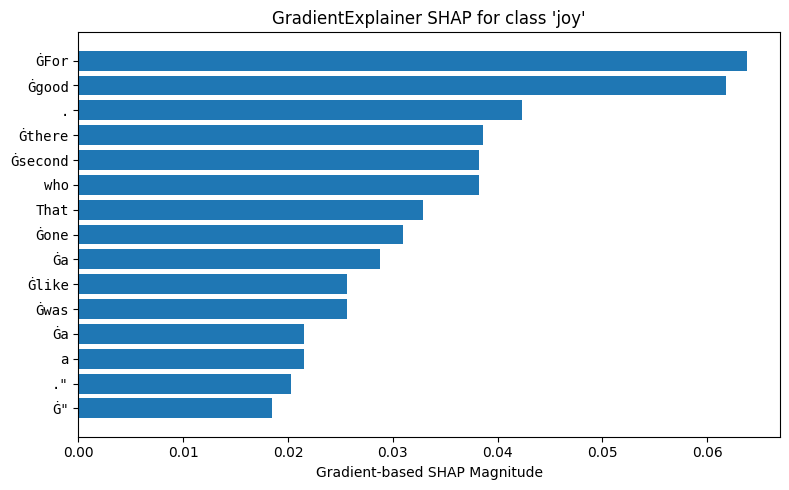

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ------------ Assumes `tokenizer`, `model`, `device` and `text` are already defined above ------------

# ===============================================
# 2) Define the embedding‐based classifier wrapper
# ===============================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # [CLS] pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch_size, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(model).to(device)
wrapped_model.eval()

# ===============================================
# 3) Create a two‐input nn.Module wrapper for SHAP
# ===============================================
class SHAPModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ===============================================
# 4) Prepare the background dataset (20 random utterances)
# ===============================================
df = pd.read_csv("/content/train_sent_emo_cleaned_processed.csv", encoding="utf-8")
background_texts = df["Utterance"].sample(20, random_state=0).tolist()

enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (20, seq_len)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (20, seq_len)

# Obtain embeddings from the model’s embedding layer
emb_layer = model.roberta.embeddings.word_embeddings
with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (20, seq_len, hidden_dim)

# SHAP background is the pair [embeddings, mask]
background = [inputs_embeds_bg, attention_mask_bg]

# ===============================================
# 5) Instantiate the GradientExplainer
# ===============================================
explainer = shap.GradientExplainer(
    shap_model,
    background
)

# ===============================================
# 6) Explain the pre‑defined `text`
# ===============================================
print("Text to explain:", text)

enc0 = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids0      = enc0["input_ids"].to(device)       # (1, seq_len)
attention_mask0 = enc0["attention_mask"].to(device)  # (1, seq_len)

with torch.no_grad():
    inputs_embeds0 = emb_layer(input_ids0)            # (1, seq_len, hidden_dim)

test_input = [inputs_embeds0, attention_mask0]

# Compute SHAP values
raw_shap = explainer.shap_values(test_input)

# ===============================================
# 7) Extract only the embedding‐dimension attributions
# ===============================================
# raw_shap[0] has shape (1, seq_len, hidden_dim, num_labels)
shap_emb = raw_shap[0][0]   # → (seq_len, hidden_dim, num_labels)
seq_len, hidden_dim, num_labels = shap_emb.shape

# For each class, compute L2 norm over hidden_dim → scalar per token
shap_vals_per_class = []
for c in range(num_labels):
    vals_c = shap_emb[:, :, c]                 # (seq_len, hidden_dim)
    token_attr = np.linalg.norm(vals_c, axis=1)  # (seq_len,)
    shap_vals_per_class.append(token_attr)
shap_vals_per_class = np.vstack(shap_vals_per_class)  # (num_labels, seq_len)

# ===============================================
# 8) Identify the predicted class and the top tokens
# ===============================================
with torch.no_grad():
    logits0 = wrapped_model(inputs_embeds0, attention_mask0)  # (1, num_labels)
    probs0  = torch.softmax(logits0, dim=-1)[0].cpu().numpy()  # (num_labels,)

pred_idx   = int(np.argmax(probs0))
pred_label = model.config.id2label[pred_idx]

# Convert input IDs back to BPE tokens
tokens_bpe = tokenizer.convert_ids_to_tokens(input_ids0[0].cpu().numpy())

# Filter out special tokens
filtered = [
    (tok, attr)
    for tok, attr in zip(tokens_bpe, shap_vals_per_class[pred_idx])
    if tok not in tokenizer.all_special_tokens
]
filtered_tokens, filtered_shap = zip(*filtered)
filtered_tokens = np.array(filtered_tokens)
filtered_shap   = np.array(filtered_shap)

# Choose top‐K tokens (up to 15)
top_k = min(len(filtered_tokens), 15)
order = np.argsort(filtered_shap)[-top_k:][::-1]
top_tokens = filtered_tokens[order]
top_values = filtered_shap[order]

# ===============================================
# 9) Plot a horizontal bar chart of the top tokens
# ===============================================
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(top_tokens))
plt.barh(y_pos, top_values, color='tab:blue', align='center')
plt.yticks(y_pos, top_tokens, fontsize=10, family='monospace')
plt.xlabel("Gradient‐based SHAP Magnitude")
plt.title(f"GradientExplainer SHAP for class '{pred_label}'")
plt.gca().invert_yaxis()  # highest‐importance at the top
plt.tight_layout()
plt.savefig("plots/gradshap_instance.png", bbox_inches="tight")
plt.show()


In [ ]:

# ===============================================
# 2) Define the embedding‐based classifier wrapper
# ===============================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        """
        inputs_embeds:    (batch_size, seq_len, hidden_dim)
        attention_mask:   (batch_size, seq_len)
        """
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # <s> token pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch_size, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(model).to(device)
wrapped_model.eval()

# ===============================================
# 3) Wrap it in a two‐input nn.Module for SHAP
# ===============================================
class SHAPModel(torch.nn.Module):
    """
    Wraps a two‐input model (embeddings + attention_mask)
    into an nn.Module whose forward() accepts exactly those two tensors.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ===============================================
# 4) Load dataset and prepare background
# ===============================================
# Use the first 200 utterances for explanation
num_to_explain = 10
if len(df) < num_to_explain:
    raise ValueError(f"DataFrame has only {len(df)} rows (<{num_to_explain}).")

# Pick 20 random utterances (can be from among the first 200 or the whole set)
background_texts = df["Utterance"].sample(20, random_state=0).tolist()
enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (20, seq_len)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (20, seq_len)

# Obtain embeddings for background
emb_layer = model.roberta.embeddings.word_embeddings
with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (20, seq_len, hidden_dim)

# SHAP background must be a list of two tensors
background = [inputs_embeds_bg, attention_mask_bg]

# ===============================================
# 5) Instantiate the GradientExplainer
# ===============================================
explainer = shap.GradientExplainer(
    shap_model,
    background
)

# ===============================================
# 6) Specify target emotion and map to index
# ===============================================
target_emotion = "surprise"  # change to any valid label
label_to_id = {lab.lower(): idx for idx, lab in model.config.id2label.items()}
if target_emotion not in label_to_id:
    raise ValueError(
        f"Label '{target_emotion}' not found; available labels: {list(model.config.id2label.values())}"
    )
target_idx = label_to_id[target_emotion]

# ===============================================
# 7) Loop over the first 200 utterances and collect token‐wise SHAP scores
# ===============================================
token_scores = {}  # mapping from token string to list of SHAP scores

for i in range(num_to_explain):
    utterance = df["Utterance"].iloc[i]
    enc = tokenizer(
        utterance,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    input_ids = enc["input_ids"].to(device)         # (1, seq_len)
    attention_mask = enc["attention_mask"].to(device)  # (1, seq_len)

    with torch.no_grad():
        inputs_embeds = emb_layer(input_ids)        # (1, seq_len, hidden_dim)

    test_input = [inputs_embeds, attention_mask]

    raw_shap = explainer.shap_values(test_input)
    # raw_shap[0]: shape (1, seq_len, hidden_dim, num_labels)
    shap_emb = raw_shap[0][0]  # drop batch dim → (seq_len, hidden_dim, num_labels)

    # Compute L2 norm over hidden_dim for the target class → (seq_len,)
    seq_len, hidden_dim, num_labels = shap_emb.shape
    vals_c = shap_emb[:, :, target_idx]            # (seq_len, hidden_dim)
    token_attrs = np.linalg.norm(vals_c, axis=1)    # (seq_len,)

    # Convert input IDs → subword tokens
    tokens_bpe = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    # Clean tokens and accumulate scores
    for tok, score in zip(tokens_bpe, token_attrs):
        clean_tok = tok.lstrip("Ġ")
        if clean_tok and (clean_tok not in tokenizer.all_special_tokens):
            token_scores.setdefault(clean_tok, []).append(score)

# ===============================================
# 8) Compute mean SHAP score per token across all utterances
# ===============================================
mean_scores = {tok: np.mean(scores) for tok, scores in token_scores.items()}

# Convert to sorted list of (token, mean_score) descending
sorted_tokens = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)

# Select top K tokens
top_k = 20
top_tokens = sorted_tokens[:top_k]

# ===============================================
# 9) Print and plot the top tokens by mean influence
# ===============================================
print(f"Top {top_k} tokens with highest mean SHAP influence for '{target_emotion}':")
for tok, ms in top_tokens:
    print(f"  {tok:15s}  {ms:.4f}")

# Plot
tokens_plot = [tok for tok, _ in top_tokens]
scores_plot = [ms for _, ms in top_tokens]

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(tokens_plot))
plt.barh(y_pos, scores_plot, color='tab:blue', align='center')
plt.yticks(y_pos, tokens_plot, fontsize=10, family='monospace')
plt.xlabel("Mean Gradient‐based SHAP Magnitude")
plt.title(f"Top {top_k} tokens (mean influence) for '{target_emotion}' across {num_to_explain} utterances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"plots/gradshap_top_{top_k}.png", bbox_inches="tight")
plt.show()


NameError: name 'device' is not defined

In [ ]:
# ========= Helpers για subwords→λέξεις & n-grams =========
def build_word_mapping(enc, tokenizer):
    """
    enc: tokenizer(...) output για ΕΝΑ παράδειγμα (return_tensors='pt', add_special_tokens=True)
    επιστρέφει: word2tok: dict[word_id] -> [token_positions]
                words_str: λίστα string tokens (BPE)
    """
    words_str = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist())
    # Fast tokenizers (HF) δίνουν word_ids()
    try:
        word_ids = enc.word_ids(0)
    except Exception:
        # fallback: αν δεν υπάρχει word_ids, θα δουλέψεις μόνο σε subword επίπεδο
        word_ids = [None]*len(words_str)
    word2tok = {}
    for pos, wid in enumerate(word_ids):
        if wid is not None:
            word2tok.setdefault(wid, []).append(pos)
    return word2tok, words_str, word_ids

def word_text_from_wid(wid, word2tok, words_str):
    toks = [words_str[t] for t in word2tok[wid]]
    # roberta: 'Ġ' σημαίνει space πριν, αφαίρεσέ το και κόλλησε
    s = ""
    for t in toks:
        if t.startswith("Ġ"):
            s += " " + t[1:]
        else:
            s += t.replace("##","")
    return s.strip()

def make_ngrams(word2tok, max_n=3):
    """
    contiguous n-grams σε επίπεδο λέξης (2..max_n)
    γυρνάει λίστα [(tok_positions_list, phrase_text)]
    """
    ngrams = []
    wids = sorted(word2tok.keys())
    for wid in wids:
        # bigram
        if (wid+1) in word2tok and max_n >= 2:
            toks = sorted(word2tok[wid] + word2tok[wid+1])
            ngrams.append((toks, f"{wid}-{wid+1}"))  # προσωρινό όνομα, θα το φτιάξουμε μετά
        # trigram
        if (wid+1) in word2tok and (wid+2) in word2tok and max_n >= 3:
            toks = sorted(word2tok[wid] + word2tok[wid+1] + word2tok[wid+2])
            ngrams.append((toks, f"{wid}-{wid+1}-{wid+2}"))
    return ngrams

def pretty_phrase_name(name_key, word2tok, words_str):
    # name_key: "wid-wid(+wid)" -> χτίσε πραγματικό string
    parts = [int(x) for x in name_key.split("-")]
    s = ""
    for wid in parts:
        s2 = word_text_from_wid(wid, word2tok, words_str)
        s += (" " if s else "") + s2
    return s

# ========= 1) Πάρε GS token scores για ένα utterance =========
# Έχεις ήδη explainer/background/emb_layer κ.λπ. από τον κώδικά σου.

def gradshap_token_scores_for_utterance(utterance, target_idx, max_length=128):
    enc = tokenizer([utterance], return_tensors="pt", padding="max_length",
                    truncation=True, max_length=max_length)
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        inputs_embeds = emb_layer(input_ids)
    test_input = [inputs_embeds, attention_mask]
    raw_shap = explainer.shap_values(test_input)  # GradientExplainer
    shap_emb = raw_shap[0][0]                     # (seq_len, hidden_dim, num_labels)
    vals_c = shap_emb[:, :, target_idx]           # (seq_len, hidden_dim)
    token_attr = np.linalg.norm(vals_c, axis=1)   # (seq_len,)
    return enc, input_ids, attention_mask, token_attr

# ========= 2) Από GS tokens → υποψήφια n-grams γύρω από top tokens =========
def candidate_ngrams_from_gs(enc, token_attr, top_k_tokens=30, max_n=3):
    word2tok, words_str, word_ids = build_word_mapping(enc, tokenizer)
    if not word2tok:
        raise ValueError("Ο tokenizer δεν δίνει word_ids(), δοκίμασε fast tokenizer ή δούλεψε σε subwords.")

    # χαρτογράφηση token_pos -> word_id (για να ξέρουμε ποια λέξη είναι “hot”)
    tok2word = {pos: wid for pos, wid in enumerate(word_ids) if wid is not None}

    # top token positions (αγνόησε special tokens)
    specials = set(tokenizer.all_special_ids)
    token_positions = [i for i in range(enc["input_ids"].shape[1])
                       if int(enc["input_ids"][0, i]) not in specials]
    top_tok_pos = sorted(token_positions, key=lambda p: token_attr[p], reverse=True)[:top_k_tokens]

    # φτιάξε n-grams από ΟΛΕΣ τις συνεχόμενες λέξεις, μετά θα φιλτράρουμε με GS άθροισμα
    ngrams = make_ngrams(word2tok, max_n=max_n)
    # όνομα φράσης
    ngrams = [(toks, pretty_phrase_name(name, word2tok, words_str)) for toks, name in ngrams]

    # score φράσης = άθροισμα |GS| των token positions της
    scored = []
    for toks, name in ngrams:
        score = float(np.sum(np.abs(token_attr[toks])))
        # προαιρετικό: απαίτησε η φράση να περιέχει τουλάχιστον 1 από τα top tokens
        if any(t in top_tok_pos for t in toks):
            scored.append((toks, name, score))
    # ταξινόμηση φράσεων κατά score
    scored.sort(key=lambda x: x[2], reverse=True)
    return scored, word2tok, words_str

# ========= 3) Greedy non-overlap επιλογή M φράσεων =========
def select_non_overlapping(scored_candidates, M=25):
    selected_groups, selected_names = [], []
    used = set()
    for toks, name, _ in scored_candidates:
        if any(t in used for t in toks):
            continue
        selected_groups.append(toks)
        selected_names.append(name)
        for t in toks: used.add(t)
        if len(selected_groups) >= M:
            break
    return selected_groups, selected_names

# ========= 4) KernelSHAP πάνω στις φράσεις (groups) =========
def mask_groups_with_id(ids, groups, z, mask_id):
    out = ids.clone()
    for g_idx, on in enumerate(z):
        if int(on) == 0:
            for p in groups[g_idx]:
                out[0, p] = mask_id
    return out

def kernelshap_over_phrases(input_ids, attention_mask, groups, nsamples=1200, use_background=False, background_ids_list=None):
    MASK_ID = tokenizer.mask_token_id
    def predict_fn(z_batch):
        vals = []
        with torch.no_grad():
            for z in z_batch:
                ids2 = mask_groups_with_id(input_ids, groups, z, MASK_ID)
                # in-distribution masking (optional): αντικατάστησε με background ids
                if use_background and background_ids_list:
                    # μίγμα: για κάθε group off, τράβα ένα background δείγμα ίδιας θέσης
                    # (άφησέ το απλό ή κάνε μέσο όρο πάνω σε 2-3 backgrounds)
                    pass
                embeds2 = emb_layer(ids2)  # (1, L, H)
                logits = wrapped_model(embeds2, attention_mask)
                vals.append(float(logits[0, target_idx]))
        return np.array(vals)

    G = len(groups)
    background = np.zeros((1, G), dtype=int)  # όλα off ως baseline (μπορείς να προσθέσεις και random)
    expl = shap.KernelExplainer(predict_fn, background)
    z_star = np.ones(G, dtype=int)
    phi_groups = expl.shap_values(z_star, nsamples=nsamples)  # (G,)
    # Προαιρετικά interactions:
    # phi_inter = expl.shap_interaction_values(z_star, nsamples=nsamples)  # (G, G)
    return np.array(phi_groups)  # , phi_inter

# ========= 5) End-to-end για ένα utterance =========
def shap_on_ngrams_for_utterance(utterance, target_idx, top_k_tokens=30, M=25, max_n=3, nsamples=1200):
    enc, input_ids, attention_mask, token_attr = gradshap_token_scores_for_utterance(
        utterance, target_idx, max_length=128
    )
    scored, word2tok, words_str = candidate_ngrams_from_gs(enc, token_attr, top_k_tokens=top_k_tokens, max_n=max_n)
    groups, names = select_non_overlapping(scored, M=M)
    phi = kernelshap_over_phrases(input_ids, attention_mask, groups, nsamples=nsamples)

    ranked = sorted([(names[i], float(phi[i])) for i in range(len(groups))],
                    key=lambda x: abs(x[1]), reverse=True)
    return ranked, groups  # κορυφαίες φράσεις + οι token θέσεις τους


In [ ]:
utter = df["Utterance"].iloc[0]           # ή όποιο δείγμα θες
target_emotion = "surprise"
target_idx = label_to_id[target_emotion]

top_phrases, groups = shap_on_ngrams_for_utterance(
    utter, target_idx,
    top_k_tokens=30,   # πόσα “άγκυρα” tokens από GS
    M=25,              # τελικές φράσεις-features (μη επικαλυπτόμενες)
    max_n=3,           # bigrams + trigrams
    nsamples=1200
)

print("\nTop φράσεις (|SHAP|):")
for name, v in top_phrases[:15]:
    print(f"{name:40s}  {v:+.4f}")



Top φράσεις (|SHAP|):
my company âĢĻ                            +0.1244
system .                                  -0.1093
s transition from                         +0.1021
point person on                           -0.0964
GR - 6                                    -0.0926
also I was                                +0.0484
KL - 5                                    -0.0131


In [ ]:
# -*- coding: utf-8 -*-
# ============================================================
# Global n-grams for BERT/RoBERTa ERC:
# - Word-level GradientSHAP (via embeddings wrapper)
# - Global n-gram ranking by mean |GS|
# - (Optional) KernelSHAP over phrase groups for final Shapley scores
# ============================================================

import math
import numpy as np
import torch
import shap
from collections import defaultdict
device = torch.device("cpu")
# ============================================================
# 0) Assumptions / Config
# ============================================================
# ΑΠΑΡΑΙΤΗΤΟ: fast tokenizer (use_fast=True by default)
# Υποθέτω ότι υπάρχουν:
#   - model (HF sequence classifier με .roberta + classifier head)
#   - tokenizer (HF fast tokenizer)
#   - df: pandas DataFrame με στήλη "Utterance"
#   - device: torch.device("cuda" ή "cpu")

target_emotion = "surprise"   # άλλαξέ το σε οποιαδήποτε ετικέτα του μοντέλου
num_to_explain = 10          # πόσα utterances για GS/global n-grams (βάλε 200-500)
max_seq_len = 96
top_k_tokens = 30             # πόσα "καυτά" tokens/λέξεις ανά doc να λαμβάνονται υπόψη για υποψηφίους n-grams
max_n = 2                     # 2: bigrams, 3: bigrams+trigrams
top_words_k = 15              # για debug/print των top λέξεων (GS)
top_phrases_m = 10           # πόσες φράσεις θα τυπώσουμε από το GS-based global ranking

# KernelSHAP (προαιρετικό, πιο αργό)
use_kernelshap = False        # βάλε True αν θες τελικό Shapley-consistent scoring
ks_sample_docs = 20          # πόσα utterances θα σκανάρεις με KernelSHAP
ks_nsamples = 20            # nsamples για KernelSHAP (σταθερότητα vs κόστος)
ks_max_groups_per_doc = 20    # όριο φράσεων (groups) ανά utterance

# ============================================================
# 1) Wrapper όπως τον έχεις + SHAP model
# ============================================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # <s> token pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(model).to(device)
wrapped_model.eval()

class SHAPModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ============================================================
# 2) Background για SHAP (embeddings + attention)
# ============================================================
if len(df) < num_to_explain:
    raise ValueError(f"DataFrame has only {len(df)} rows (<{num_to_explain}).")

bg_count = min(5, len(df))
background_texts = df["Utterance"].sample(bg_count, random_state=0).tolist()
enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=max_seq_len
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (B, L)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (B, L)

# Embedding layer
emb_layer = model.roberta.embeddings.word_embeddings

with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (B, L, H)

background = [inputs_embeds_bg, attention_mask_bg]

explainer = shap.GradientExplainer(shap_model, background)

# ============================================================
# 3) Χάρτης ετικετών → index στόχου
# ============================================================
label_to_id = {lab.lower(): idx for idx, lab in model.config.id2label.items()}
if target_emotion.lower() not in label_to_id:
    raise ValueError(f"Label '{target_emotion}' not found; available: {list(model.config.id2label.values())}")
target_idx = label_to_id[target_emotion.lower()]

# ============================================================
# 4) Helpers: word-level mapping + scoring
# ============================================================
def gs_token_scores_one(utter):
    """
    Επιστρέφει:
      enc: tokenizer output (με offsets & word_ids)
      input_ids, attention_mask (στο device)
      token_attr: (L,) GS magnitude per token
    """
    enc = tokenizer(
        utter,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_seq_len,
        return_offsets_mapping=True  # για ακριβές string από το original κείμενο
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        inputs_embeds = emb_layer(input_ids)
    raw = explainer.shap_values([inputs_embeds, attention_mask])  # GradientExplainer
    # raw[0]: (1, L, H, C)
    shap_emb = raw[0][0]                        # (L, H, C)
    vals_c = shap_emb[:, :, target_idx]         # (L, H)
    token_attr = np.linalg.norm(vals_c, axis=1) # (L,)
    return enc, input_ids, attention_mask, token_attr

def word_level_from_enc(utter, enc, token_attr, attn_mask):
    """
    Συγκεντρώνει GS από subwords σε ΛΕΞΕΙΣ με word_ids() και offsets.
    Επιστρέφει:
      ordered_wids: λίστα από word indices (ταξινομημένα)
      wid_attr: dict[wid] -> sum|GS|
      wid_span: dict[wid] -> [start_char, end_char] στο original utterance
    """
    offsets = enc["offset_mapping"][0].cpu().tolist()  # [(s,e), ...]
    word_ids = enc.word_ids(0)                         # [wid or None]
    L = enc["input_ids"].shape[1]

    wid_attr = defaultdict(float)
    wid_span = {}

    for pos in range(L):
        wid = word_ids[pos]
        if wid is None:
            continue
        if attn_mask[0, pos].item() == 0:
            continue
        wid_attr[wid] += float(token_attr[pos])
        s, e = offsets[pos]
        if wid not in wid_span:
            wid_span[wid] = [s, e]
        else:
            wid_span[wid][0] = min(wid_span[wid][0], s)
            wid_span[wid][1] = max(wid_span[wid][1], e)

    ordered_wids = sorted(wid_attr.keys())
    return ordered_wids, wid_attr, wid_span

# ============================================================
# 5) Global collection: WORDS + n-GRAMS (GS-based)
# ============================================================
global_word_scores = defaultdict(list)   # word_text -> [GS]
global_phrase_scores = defaultdict(list) # phrase_text -> [GS_sum]

N = min(num_to_explain, len(df))
for i in range(N):
    utter = df["Utterance"].iloc[i]

    enc, ids, attn, token_attr = gs_token_scores_one(utter)
    ordered_wids, wid_attr, wid_span = word_level_from_enc(utter, enc, token_attr, attn)

    # ----- WORDS (global)
    for wid in ordered_wids:
        s, e = wid_span[wid]
        wtxt = utter[s:e].strip()
        if wtxt:
            global_word_scores[wtxt].append(wid_attr[wid])

    # ----- περιορισμός στους "top" με βάση token_attr (για να περιορίσουμε n-gram search)
    # Βρίσκουμε τις κορυφαίες θέσεις token στο doc για καθοδήγηση n-gram
    specials = set(tokenizer.all_special_ids)
    valid_positions = [p for p in range(enc["input_ids"].shape[1]) if int(enc["input_ids"][0, p]) not in specials]
    top_pos = set(sorted(valid_positions, key=lambda p: token_attr[p], reverse=True)[:top_k_tokens])

    # map: token_pos -> ανήκει στο span κάποιας λέξης (για να δούμε αν n-gram "αγγίζει" top token)
    pos_to_wid = {pos: wid for pos, wid in enumerate(enc.word_ids(0)) if wid is not None}

    def phrase_text(span_wids):
        s = min(wid_span[w][0] for w in span_wids)
        e = max(wid_span[w][1] for w in span_wids)
        return utter[s:e].strip(), s, e

    # ----- BIGRAMS / TRIGRAMS σε επίπεδο λέξης
    for k in range(len(ordered_wids) - 1):
        w1, w2 = ordered_wids[k], ordered_wids[k+1]
        # έλεγξε αν το n-gram περιλαμβάνει κάποια top token θέση
        tok_positions = []
        for w in (w1, w2):
            s, e = wid_span[w]
            # προσεγγιστικά: όλα τα token positions που ανήκουν στο char-span (ασφαλές αρκετά)
            # (θα μπορούσες να το χαρτογραφήσεις ακριβέστερα με offsets ανά token αν θες)
        # GS score του bigram = sum των word GS
        ptxt, _, _ = phrase_text([w1, w2])
        if ptxt:
            score = wid_attr[w1] + wid_attr[w2]
            global_phrase_scores[ptxt].append(score)

    if max_n >= 3:
        for k in range(len(ordered_wids) - 2):
            w1, w2, w3 = ordered_wids[k], ordered_wids[k+1], ordered_wids[k+2]
            ptxt, _, _ = phrase_text([w1, w2, w3])
            if ptxt:
                score = wid_attr[w1] + wid_attr[w2] + wid_attr[w3]
                global_phrase_scores[ptxt].append(score)

# ============================================================
# 6) Global ranking (GS-based)
# ============================================================
mean_word_scores = {w: float(np.mean(v)) for w, v in global_word_scores.items() if w and any(c.isalnum() for c in w)}
sorted_words = sorted(mean_word_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop {top_words_k} WORDS by mean |GS| for '{target_emotion}' across {N} utterances:")
for w, s in sorted_words[:top_words_k]:
    print(f"  {w:30s}  {s:.4f}")

mean_phrase_scores = {p: float(np.mean(v)) for p, v in global_phrase_scores.items()
                      if p and any(c.isalnum() for c in p) and len(p) >= 2}
sorted_phrases = sorted(mean_phrase_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop {top_phrases_m} PHRASES (n-grams) by mean |GS|:")
for p, s in sorted_phrases[:top_phrases_m]:
    print(f"  {p:40s}  {s:+.4f}")

# ============================================================
# 7) (Optional) KernelSHAP πάνω στις φράσεις για Shapley-consistent global
# ============================================================
def score_logit(input_ids, attention_mask, target_idx):
    with torch.no_grad():
        embeds = emb_layer(input_ids)
        logits = wrapped_model(embeds, attention_mask)
        return float(logits[0, target_idx])

def kernelshap_utterance_over_phrases(utter, phrase_types, nsamples=800, max_groups_per_doc=20):
    """Βρίσκει εμφανίσεις των phrase_types στο utter (με word-level matching),
       επιλέγει μη-επικαλυπτόμενες, τρέχει KernelSHAP σε groups (mask όλα τα tokens της φράσης)."""
    enc = tokenizer(
        utter, return_tensors="pt", padding="max_length", truncation=True, max_length=max_seq_len,
        return_offsets_mapping=True
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    word_ids = enc.word_ids(0)
    offsets = enc["offset_mapping"][0].cpu().tolist()

    # φτιάξε mapping wid -> (start_char,end_char)
    wid_span = {}
    for pos, wid in enumerate(word_ids):
        if wid is None or attention_mask[0, pos].item() == 0:
            continue
        s, e = offsets[pos]
        if wid not in wid_span:
            wid_span[wid] = [s, e]
        else:
            wid_span[wid][0] = min(wid_span[wid][0], s)
            wid_span[wid][1] = max(wid_span[wid][1], e)

    wids = sorted(wid_span.keys())
    def wid_text(ww):
        s, e = wid_span[ww]
        return utter[s:e]

    wid2txt = {wid: wid_text(wid) for wid in wids}
    phrase_splits = [(p, p.split()) for p in phrase_types]

    # εύρεση εμφανίσεων με sliding σε επίπεδο word
    occ_groups, occ_names = [], []
    for start in wids:
        for ptxt, toks in phrase_splits:
            Lw = len(toks)
            seq = []
            ok = True
            for k in range(Lw):
                wid_k = start + k
                if wid_k not in wid2txt:
                    ok = False; break
                seq.append(wid2txt[wid_k].strip().lower())
            if not ok:
                continue
            if seq == [t.lower() for t in toks]:
                # μάζεψε ΟΛΕΣ τις token-positions που πέφτουν στο char-span των word ids
                s = min(wid_span[start + k][0] for k in range(Lw))
                e = max(wid_span[start + k][1] for k in range(Lw))
                # token positions που καλύπτουν το [s,e)
                tok_positions = []
                for pos, wid in enumerate(word_ids):
                    if wid is None: continue
                    ts, te = offsets[pos]
                    if ts >= s and te <= e:
                        tok_positions.append(pos)
                occ_groups.append(sorted(tok_positions))
                occ_names.append(ptxt)

    # greedy non-overlap
    used, groups, names = set(), [], []
    for tpos, name in sorted(zip(occ_groups, occ_names), key=lambda x: -len(x[0])):
        if any(p in used for p in tpos):
            continue
        groups.append(tpos)
        names.append(name)
        for p in tpos: used.add(p)
        if len(groups) >= max_groups_per_doc:
            break

    if not groups:
        return {}

    MASK_ID = tokenizer.mask_token_id
    def predict_fn(z_batch):
        vals = []
        with torch.no_grad():
            for z in z_batch:
                ids2 = input_ids.clone()
                for gi, on in enumerate(z):
                    if int(on) == 0:
                        for p in groups[gi]:
                            ids2[0, p] = MASK_ID
                vals.append(score_logit(ids2, attention_mask, target_idx))
        return np.array(vals)

    background = np.zeros((1, len(groups)), dtype=int)  # όλα off
    expl = shap.KernelExplainer(predict_fn, background)
    z_star = np.ones(len(groups), dtype=int)
    phi = expl.shap_values(z_star, nsamples=nsamples)  # (G,)
    out = defaultdict(list)
    for gi, name in enumerate(names):
        out[name].append(float(phi[gi]))
    return out

def global_kernelshap_rank(df, phrase_types, sample_docs=200, nsamples=1000, max_groups_per_doc=20):
    agg = defaultdict(list)
    D = min(sample_docs, len(df))
    for i in range(D):
        utter = df["Utterance"].iloc[i]
        res = kernelshap_utterance_over_phrases(
            utter, phrase_types,
            nsamples=nsamples,
            max_groups_per_doc=max_groups_per_doc
        )
        for name, vals in res.items():
            agg[name].extend(vals)
    ranked = []
    for name, vals in agg.items():
        mean_abs = float(np.mean(np.abs(vals)))
        support  = len(vals)
        total_abs = float(np.sum(np.abs(vals)))
        ranked.append((name, mean_abs, support, total_abs))
    ranked.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return ranked

if use_kernelshap:
    # πάρε τις top φράσεις από GS-based ranking ως τύπους προς έλεγχο
    phrase_types = [p for p, _ in sorted_phrases[:top_phrases_m]]
    ranked_global = global_kernelshap_rank(
        df, phrase_types,
        sample_docs=ks_sample_docs,
        nsamples=ks_nsamples,
        max_groups_per_doc=ks_max_groups_per_doc
    )
    print("\n[KernelSHAP] Global φράσεις (mean|SHAP|, support, total|SHAP|):")
    for name, mean_abs, support, total_abs in ranked_global[:top_phrases_m]:
        print(f"{name:40s}  mean|SHAP|={mean_abs:.4f}  n={support}  total|SHAP|={total_abs:.2f}")



Top 15 WORDS by mean |GS| for 'surprise' across 10 utterances:
  Good                            0.1576
  must                            0.1403
  full                            0.1266
  know                            0.1233
  hands                           0.1143
  see                             0.1093
  right                           0.1038
  heading                         0.0964
  All                             0.0914
  My                              0.0895
  duties                          0.0890
  division                        0.0866
  ve                              0.0779
  You                             0.0743
  also                            0.0739

Top 10 PHRASES (n-grams) by mean |GS|:
  duties?                                   +0.2856
  My duties                                 +0.2457
  hands full                                +0.2408
  must’                                     +0.2343
  Good to                                   +0.2336
  right.             

In [ ]:
!pip install bertviz

In [ ]:
from bertviz import head_view, model_view

def visualize_attention(model, tokenizer, sample_text, stage="Pre Fine-Tuning"):
    # Ensure the model outputs attentions
    model.config.output_attentions  = True
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # Tuple of attention tensors for each layer
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    print(f"\n--- {stage} Attention Visualization (Head View) ---")
    head_view(attentions, tokens)

    print(f"\n--- {stage} Attention Visualization (Model View) ---")
    model_view(attentions, tokens)

# Load the model with attn_implementation="eager" to enable attention output
model = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-base", attn_implementation="eager")



visualize_attention(model, tokenizer,text, stage="Pre Fine-Tuning")

In [ ]:
# -*- coding: utf-8 -*-
# ============================================================
# Global n-grams for BERT/RoBERTa ERC:
# - Word-level GradientSHAP (via embeddings wrapper)
# - Global n-gram ranking by mean |GS|
# - (Optional) KernelSHAP over phrase groups for final Shapley scores
# ============================================================

import math
import re
import unicodedata
import numpy as np
import torch
import shap
from collections import defaultdict

# ------------------------------------------------------------
# Συσκευή
# ------------------------------------------------------------
device = torch.device("cpu")  # άλλαξε σε "cuda" αν θες GPU

# ============================================================
# 0) Assumptions / Config
# ============================================================
# Προϋπάρχουν:
#   - model (HF sequence classifier με .roberta + classifier head)
#   - tokenizer (HF fast tokenizer)
#   - df: pandas DataFrame με στήλη "Utterance"

target_emotion = "surprise"   # κλάση στόχος
num_to_explain = 10           # utterances για GS/global n-grams (π.χ. 200–500 για σοβαρό run)
max_seq_len = 96
top_k_tokens = 30             # "καυτά" tokens/λέξεις ανά doc για n-gram candidates
max_n = 2                     # 2: bigrams, 3: bigrams+trigrams
top_words_k = 15              # εκτύπωση top λέξεων
top_phrases_m = 10            # εκτύπωση top φράσεων

# --- ΝΕΑ FLAGS για στίξη / n-grams ---
min_n = 1          # επιτρέπουμε μονολέξεις (π.χ. "?", "!", "—"); βάλε 2 αν θες μόνο ≥2 λέξεις
keep_punct = True  # κρατάμε σημεία στίξης στο post-processing (δεν κόβουμε τελική στίξη)

# KernelSHAP (προαιρετικό)
use_kernelshap = False
ks_sample_docs = 20
ks_nsamples = 20
ks_max_groups_per_doc = 20

# ============================================================
# 1) Wrapper όπως τον έχεις + SHAP model
# ============================================================
class EmbeddingWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.roberta  = hf_model.roberta
        self.dropout  = hf_model.classifier.dropout
        self.dense    = hf_model.classifier.dense
        self.out_proj = hf_model.classifier.out_proj

    def forward(self, inputs_embeds, attention_mask):
        outputs = self.roberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]   # <s> token pooling
        x = self.dropout(pooled)
        x = self.dense(x)
        x = torch.nn.functional.gelu(x)
        logits = self.out_proj(x)                     # (batch, num_labels)
        return logits

wrapped_model = EmbeddingWrapper(model).to(device)
wrapped_model.eval()

class SHAPModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, inputs_embeds, attention_mask):
        return self.base_model(inputs_embeds, attention_mask)

shap_model = SHAPModel(wrapped_model)

# ============================================================
# 2) Background για SHAP (embeddings + attention)
# ============================================================
if len(df) < num_to_explain:
    raise ValueError(f"DataFrame has only {len(df)} rows (<{num_to_explain}).")

bg_count = min(5, len(df))  # μικρό για γρήγορο run (αργότερα 20–50 για σταθερότητα)
background_texts = df["Utterance"].sample(bg_count, random_state=0).tolist()
enc_bg = tokenizer(
    background_texts,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=max_seq_len
)
input_ids_bg      = enc_bg["input_ids"].to(device)       # (B, L)
attention_mask_bg = enc_bg["attention_mask"].to(device)  # (B, L)

# Embedding layer
emb_layer = model.roberta.embeddings.word_embeddings
with torch.no_grad():
    inputs_embeds_bg = emb_layer(input_ids_bg)           # (B, L, H)

background = [inputs_embeds_bg, attention_mask_bg]
explainer = shap.GradientExplainer(shap_model, background)

# ============================================================
# 3) Χάρτης ετικετών → index στόχου
# ============================================================
label_to_id = {lab.lower(): idx for idx, lab in model.config.id2label.items()}
if target_emotion.lower() not in label_to_id:
    raise ValueError(f"Label '{target_emotion}' not found; available: {list(model.config.id2label.values())}")
target_idx = label_to_id[target_emotion.lower()]

# ============================================================
# 4) κανονικοποίηση στίξης / word-level mapping
# ============================================================
def normalize_punct(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    # ομογενοποίηση αποστρόφων & παυλών
    s = s.replace("’","'").replace("`","'").replace("´","'").replace("‘","'")
    s = s.replace("—","–").replace("‒","–").replace("--","–")
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

def clean_text_keep_or_strip_punct(text: str, keep_punct: bool) -> str:
    t = normalize_punct(text.lower())
    if not keep_punct:
        # κόψε τελική στίξη ΜΟΝΟ αν το ζητάς
        t = re.sub(r"[.,!?;:…]+$", "", t).strip()
    return t

def is_punct_only(s: str) -> bool:
    # True αν αποτελείται αποκλειστικά από μη-αλφαριθμητικά (π.χ. "?!", "—")
    return bool(re.fullmatch(r"[^\w]+", s))

def is_valid_ngram(s: str, min_n: int) -> bool:
    # μετρά tokens με split στο κενό — η στίξη μετρά σαν token
    return len(s.split()) >= min_n and len(s) > 0

def gs_token_scores_one(utter):
    """
    Επιστρέφει:
      enc: tokenizer output (με offsets & word_ids)
      input_ids, attention_mask (στο device)
      token_attr: (L,) GS magnitude per token
    """
    enc = tokenizer(
        utter,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_seq_len,
        return_offsets_mapping=True
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        inputs_embeds = emb_layer(input_ids)
    raw = explainer.shap_values([inputs_embeds, attention_mask])  # GradientExplainer
    # raw[0]: (1, L, H, C)
    shap_emb = raw[0][0]                        # (L, H, C)
    vals_c = shap_emb[:, :, target_idx]         # (L, H)
    token_attr = np.linalg.norm(vals_c, axis=1) # (L,)
    return enc, input_ids, attention_mask, token_attr

def word_level_from_enc(utter, enc, token_attr, attn_mask):
    """
    Συγκεντρώνει GS από subwords σε ΛΕΞΕΙΣ με word_ids() και offsets.
    Επιστρέφει:
      ordered_wids: λίστα από word indices (ταξινομημένα)
      wid_attr: dict[wid] -> sum|GS|
      wid_span: dict[wid] -> [start_char, end_char] στο original utterance
    """
    offsets = enc["offset_mapping"][0].cpu().tolist()  # [(s,e), ...]
    word_ids = enc.word_ids(0)                         # [wid or None]
    L = enc["input_ids"].shape[1]

    wid_attr = defaultdict(float)
    wid_span = {}

    for pos in range(L):
        wid = word_ids[pos]
        if wid is None:
            continue
        if attn_mask[0, pos].item() == 0:
            continue
        wid_attr[wid] += float(token_attr[pos])
        s, e = offsets[pos]
        if wid not in wid_span:
            wid_span[wid] = [s, e]
        else:
            wid_span[wid][0] = min(wid_span[wid][0], s)
            wid_span[wid][1] = max(wid_span[wid][1], e)

    ordered_wids = sorted(wid_attr.keys())
    return ordered_wids, wid_attr, wid_span


# 5) Global collection: WORDS + n-GRAMS (GS-based)

global_word_scores = defaultdict(list)   # word_text -> [GS]
global_phrase_scores = defaultdict(list) # phrase_text -> [GS_sum]

N = min(num_to_explain, len(df))
for i in range(N):
    utter = df["Utterance"].iloc[i]

    enc, ids, attn, token_attr = gs_token_scores_one(utter)
    ordered_wids, wid_attr, wid_span = word_level_from_enc(utter, enc, token_attr, attn)

    #  WORDS (global)
    for wid in ordered_wids:
        s, e = wid_span[wid]
        wtxt = utter[s:e]  # ΔΕΝ κάνουμε strip για να κρατήσουμε στίξη στην άκρη αν υπάρχει
        if wtxt:
            global_word_scores[wtxt].append(wid_attr[wid])

    #  BIGRAMS / TRIGRAMS σε επίπεδο λέξης
    def phrase_text(span_wids):
        s = min(wid_span[w][0] for w in span_wids)
        e = max(wid_span[w][1] for w in span_wids)
        return utter[s:e], s, e

    for k in range(len(ordered_wids) - 1):
        w1, w2 = ordered_wids[k], ordered_wids[k+1]
        ptxt, _, _ = phrase_text([w1, w2])
        if ptxt:
            score = wid_attr[w1] + wid_attr[w2]
            global_phrase_scores[ptxt].append(score)

    if max_n >= 3:
        for k in range(len(ordered_wids) - 2):
            w1, w2, w3 = ordered_wids[k], ordered_wids[k+1], ordered_wids[k+2]
            ptxt, _, _ = phrase_text([w1, w2, w3])
            if ptxt:
                score = wid_attr[w1] + wid_attr[w2] + wid_attr[w3]
                global_phrase_scores[ptxt].append(score)


# 6) Global ranking (GS-based) — ΜΕ στίξη & min_n

# ----- WORDS -----
_clean_words = {}
for w, vals in global_word_scores.items():
    if not w:
        continue
    t = clean_text_keep_or_strip_punct(w, keep_punct=keep_punct)
    if not is_valid_ngram(t, min_n=1):   # λέξη ή καθαρή στίξη: min_n=1
        continue
    _clean_words.setdefault(t, []).extend(vals)

mean_word_scores = {t: float(np.mean(v)) for t, v in _clean_words.items()}
sorted_words = sorted(mean_word_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop {top_words_k} WORDS by mean |GS| for '{target_emotion}' across {N} utterances:")
for w, s in sorted_words[:top_words_k]:
    print(f"  {w:30s}  {s:.4f}")

# ----- PHRASES -----
_clean_phr = {}
for p, vals in global_phrase_scores.items():
    if not p:
        continue
    t = clean_text_keep_or_strip_punct(p, keep_punct=keep_punct)
    if not is_valid_ngram(t, min_n=min_n):   # εδώ το min_n (1 ή 2) ορίζει αν κρατάς μονολέξεις
        continue
    _clean_phr.setdefault(t, []).extend(vals)

mean_phrase_scores = {t: float(np.mean(v)) for t, v in _clean_phr.items()}
sorted_phrases = sorted(mean_phrase_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop {top_phrases_m} PHRASES (n-grams) by mean |GS|:")
for p, s in sorted_phrases[:top_phrases_m]:
    print(f"  {p:40s}  {s:+.4f}")

# ============================================================
# 7) (Optional) KernelSHAP πάνω στις φράσεις για Shapley-consistent global
# ============================================================
def score_logit(input_ids, attention_mask, target_idx):
    with torch.no_grad():
        embeds = emb_layer(input_ids)
        logits = wrapped_model(embeds, attention_mask)
        return float(logits[0, target_idx])

def kernelshap_utterance_over_phrases(utter, phrase_types, nsamples=800, max_groups_per_doc=20):
    """Βρίσκει εμφανίσεις των phrase_types στο utter (με word-level matching),
       επιλέγει μη-επικαλυπτόμενες, τρέχει KernelSHAP σε groups (mask όλα τα tokens της φράσης)."""
    enc = tokenizer(
        utter, return_tensors="pt", padding="max_length", truncation=True, max_length=max_seq_len,
        return_offsets_mapping=True
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    word_ids = enc.word_ids(0)
    offsets = enc["offset_mapping"][0].cpu().tolist()

    # wid -> (start_char,end_char)
    wid_span = {}
    for pos, wid in enumerate(word_ids):
        if wid is None or attention_mask[0, pos].item() == 0:
            continue
        s, e = offsets[pos]
        if wid not in wid_span:
            wid_span[wid] = [s, e]
        else:
            wid_span[wid][0] = min(wid_span[wid][0], s)
            wid_span[wid][1] = max(wid_span[wid][1], e)

    wids = sorted(wid_span.keys())
    def wid_text(ww):
        s, e = wid_span[ww]
        return utter[s:e]

    wid2txt = {wid: wid_text(wid) for wid in wids}
    phrase_splits = [(p, p.split()) for p in phrase_types]

    # εύρεση εμφανίσεων με sliding σε επίπεδο word
    occ_groups, occ_names = [], []
    for start in wids:
        for ptxt, toks in phrase_splits:
            Lw = len(toks)
            seq = []
            ok = True
            for k in range(Lw):
                wid_k = start + k
                if wid_k not in wid2txt:
                    ok = False; break
                seq.append(wid2txt[wid_k].strip().lower())
            if not ok:
                continue
            if seq == [t.lower() for t in toks]:
                # char-span του n-gram
                s = min(wid_span[start + k][0] for k in range(Lw))
                e = max(wid_span[start + k][1] for k in range(Lw))
                # token positions που καλύπτουν το [s,e)
                tok_positions = []
                for pos, wid in enumerate(word_ids):
                    if wid is None: continue
                    ts, te = offsets[pos]
                    if ts >= s and te <= e:
                        tok_positions.append(pos)
                occ_groups.append(sorted(tok_positions))
                occ_names.append(ptxt)

    # greedy non-overlap
    used, groups, names = set(), [], []
    for tpos, name in sorted(zip(occ_groups, occ_names), key=lambda x: -len(x[0])):
        if any(p in used for p in tpos):
            continue
        groups.append(tpos)
        names.append(name)
        for p in tpos: used.add(p)
        if len(groups) >= max_groups_per_doc:
            break

    if not groups:
        return {}

    MASK_ID = tokenizer.mask_token_id
    def predict_fn(z_batch):
        vals = []
        with torch.no_grad():
            for z in z_batch:
                ids2 = input_ids.clone()
                for gi, on in enumerate(z):
                    if int(on) == 0:
                        for p in groups[gi]:
                            ids2[0, p] = MASK_ID
                vals.append(score_logit(ids2, attention_mask, target_idx))
        return np.array(vals)

    background = np.zeros((1, len(groups)), dtype=int)  # όλα off
    expl = shap.KernelExplainer(predict_fn, background)
    z_star = np.ones(len(groups), dtype=int)
    phi = expl.shap_values(z_star, nsamples=nsamples)  # (G,)
    out = defaultdict(list)
    for gi, name in enumerate(names):
        out[name].append(float(phi[gi]))
    return out

def global_kernelshap_rank(df, phrase_types, sample_docs=200, nsamples=1000, max_groups_per_doc=20):
    agg = defaultdict(list)
    D = min(sample_docs, len(df))
    for i in range(D):
        utter = df["Utterance"].iloc[i]
        res = kernelshap_utterance_over_phrases(
            utter, phrase_types,
            nsamples=nsamples,
            max_groups_per_doc=max_groups_per_doc
        )
        for name, vals in res.items():
            agg[name].extend(vals)
    ranked = []
    for name, vals in agg.items():
        mean_abs = float(np.mean(np.abs(vals)))
        support  = len(vals)
        total_abs = float(np.sum(np.abs(vals)))
        ranked.append((name, mean_abs, support, total_abs))
    ranked.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return ranked

if use_kernelshap:
    phrase_types = [p for p, _ in sorted_phrases[:top_phrases_m]]
    ranked_global = global_kernelshap_rank(
        df, phrase_types,
        sample_docs=ks_sample_docs,
        nsamples=ks_nsamples,
        max_groups_per_doc=ks_max_groups_per_doc
    )
    print("\n[KernelSHAP] Global φράσεις (mean|SHAP|, support, total|SHAP|):")
    for name, mean_abs, support, total_abs in ranked_global[:top_phrases_m]:
        print(f"{name:40s}  mean|SHAP|={mean_abs:.4f}  n={support}  total|SHAP|={total_abs:.2f}")



Top 15 WORDS by mean |GS| for 'surprise' across 10 utterances:
  good                            0.1496
  ?                               0.1394
  heading                         0.1247
  must                            0.1186
  know                            0.1186
  division                        0.1157
  full                            0.1153
  see                             0.1092
  hands                           0.1031
  right                           0.0996
  all                             0.0912
  whole                           0.0844
  duties                          0.0775
  now                             0.0714
  ve                              0.0702

Top 10 PHRASES (n-grams) by mean |GS|:
  duties?                                   +0.2861
  ?                                         +0.2477
  my duties                                 +0.2398
  good to                                   +0.2192
  hands full                                +0.2184
  must'              

In [ ]:
# ======= PLOTS =======
import os, matplotlib
import matplotlib.pyplot as plt

# (headless-friendly)
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["font.family"] = "DejaVu Sans"

os.makedirs("plots", exist_ok=True)

def plot_barh(items, top_n, title, out_png):
    """
    items: list[ (label, score) ] already sorted desc
    """
    take = items[:top_n]
    labels = [t for t,_ in take][::-1]        # flip for barh top→bottom
    scores = [float(s) for _,s in take][::-1]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(labels)), scores, align="center")
    plt.yticks(range(len(labels)), labels, fontsize=9)
    plt.xlabel("Mean |GS|", fontsize=10)
    plt.title(title, fontsize=11)
    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.close()

# 1) Top WORDS (mean |GS|)
plot_barh(sorted_words, top_words_k,
          f"Top {top_words_k} WORDS (mean |GS|) – '{target_emotion}'",
          "plots/top_words.png")

# 2) Top PHRASES (mean |GS|)
plot_barh(sorted_phrases, top_phrases_m,
          f"Top {top_phrases_m} PHRASES (mean |GS|) – '{target_emotion}'",
          "plots/top_phrases.png")

# ---------- Προαιρετικά: χωριστά plots για lexical vs punctuation ----------
import re
def is_punct_only(s: str) -> bool:
    return bool(re.fullmatch(r"[^\w]+", s))

def split_pairs(pairs):
    lex, pun = [], []
    for t, s in pairs:
        if is_punct_only(t) or re.search(r"[!?\.…–;]", t):
            pun.append((t, s))
        else:
            lex.append((t, s))
    return lex, pun

lex_phr, punct_phr = split_pairs(sorted_phrases)

if len(lex_phr) > 0:
    plot_barh(lex_phr, min(top_phrases_m, len(lex_phr)),
              f"Top PHRASES – lexical (mean |GS|) – '{target_emotion}'",
              "plots/top_phrases_lexical.png")

if len(punct_phr) > 0:
    plot_barh(punct_phr, min(top_phrases_m, len(punct_phr)),
              f"Top PHRASES – punctuation (mean |GS|) – '{target_emotion}'",
              "plots/top_phrases_punct.png")

print("Saved plots to: plots/top_words.png, plots/top_phrases.png",
      "(and lexical/punct variants if available)")



Saved plots to: plots/top_words.png, plots/top_phrases.png (and lexical/punct variants if available)


In [5]:
# --- Confusion Matrices for ERC (HuggingFace model) -------------------------
# pip install scikit-learn matplotlib

import os
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def evaluate_confusion_matrices(
    model,
    tokenizer,
    df,
    text_col="Utterance",
    label_col="Label",
    max_length=128,
    batch_size=32,
    device=None,
    out_dir="plots",
    show_plots=True,
    save_plots=True,
):
    """
    Builds y_true / y_pred, plots confusion matrices (counts, row-norm, col-norm),
    prints classification report, and returns the matrices.

    df[label_col] should contain label names matching model.config.id2label (case-insensitive OK).
    """

    # --- device
    if device is None:
        device = model.device if hasattr(model, "device") else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # --- map labels (string -> id) using model's id2label
    id2label = model.config.id2label
    num_classes = len(id2label)
    # Build a case-insensitive mapping
    label2id = {id2label[i].lower(): i for i in range(num_classes)}

    # Prepare texts and y_true
    texts = df[text_col].astype(str).tolist()
    raw_labels = df[label_col].astype(str).tolist()
    try:
        y_true = np.array([label2id[l.lower()] for l in raw_labels], dtype=int)
    except KeyError as e:
        missing = set([l for l in raw_labels if l.lower() not in label2id])
        raise ValueError(f"Found labels not present in the model mapping: {missing}. "
                         f"Model labels are: {list(id2label.values())}")

    # --- batched prediction
    preds = []
    with torch.no_grad():
        for start in range(0, len(texts), batch_size):
            batch = texts[start:start+batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits  # (B, C)
            preds.append(logits.argmax(dim=-1).detach().cpu().numpy())
    y_pred = np.concatenate(preds, axis=0)

    # --- class names in correct order
    class_names = [id2label[i] for i in range(num_classes)]

    # --- confusion matrices
    labels_idx = list(range(num_classes))
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx)
    cm_row    = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="true")  # per-true (recall)
    cm_col    = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="pred")  # per-pred (precision)

    # --- plots
    if save_plots:
        os.makedirs(out_dir, exist_ok=True)

    def _plot(cm, title, fname):
        fig, ax = plt.subplots(figsize=(7, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(include_values=True, cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.tight_layout()
        if save_plots:
            path = os.path.join(out_dir, fname)
            plt.savefig(path, bbox_inches="tight", dpi=150)
        if show_plots:
            plt.show()
        plt.close(fig)

    _plot(cm_counts, "Confusion Matrix (counts)",       "cm_counts.png")
    _plot(cm_row,    "Confusion Matrix (row-norm = recall)", "cm_row_norm.png")
    _plot(cm_col,    "Confusion Matrix (col-norm = precision)", "cm_col_norm.png")

    # --- per-class metrics
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    return {
        "cm_counts": cm_counts,
        "cm_row_norm": cm_row,
        "cm_col_norm": cm_col,
        "class_names": class_names,
        "y_true": y_true,
        "y_pred": y_pred,
    }


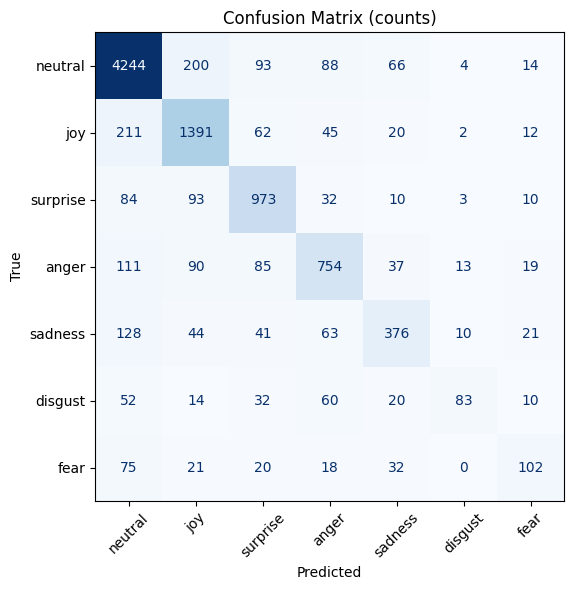

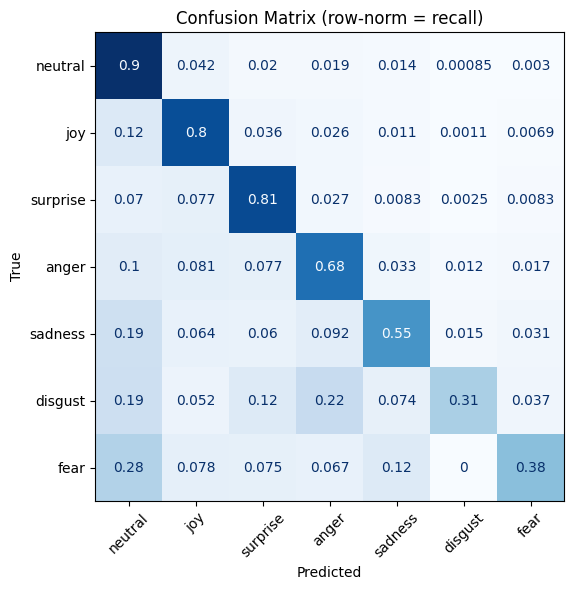

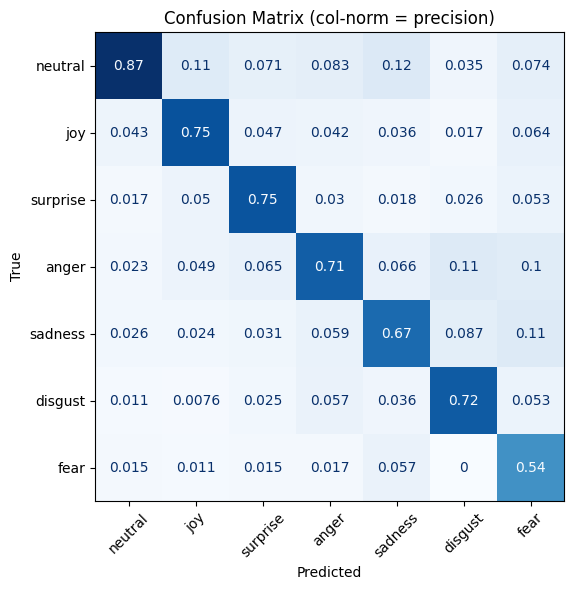

              precision    recall  f1-score   support

     neutral      0.865     0.901     0.883      4709
         joy      0.751     0.798     0.774      1743
    surprise      0.745     0.807     0.775      1205
       anger      0.711     0.680     0.695      1109
     sadness      0.670     0.551     0.605       683
     disgust      0.722     0.306     0.430       271
        fear      0.543     0.381     0.447       268

    accuracy                          0.793      9988
   macro avg      0.715     0.632     0.658      9988
weighted avg      0.788     0.793     0.787      9988



In [7]:
results = evaluate_confusion_matrices(
    model,
    tokenizer,
    df,
    text_col="Utterance",
    label_col="Emotion",
    max_length=128,
    batch_size=32,
    device=None,
    out_dir="plots",
    show_plots=True,
    save_plots=True,
)